# Redes Neuronales.

In [8]:
import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
import gc
import sys
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf


print(f"Tensorflow Version: {tf.__version__}")
print(f"Pandas Version: {pd.__version__}")
print(f"Numpy Version: {np.__version__}")
print(f"System Version: {sys.version}")

mpl.rcParams['figure.figsize'] = (17, 5)
mpl.rcParams['axes.grid'] = False
sns.set_style("whitegrid")

notebookstart= time.time()

Tensorflow Version: 2.9.2
Pandas Version: 1.3.5
Numpy Version: 1.21.6
System Version: 3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]


In [9]:
import IPython
import IPython.display

## Datos:

In [10]:
df = pd.read_csv("bitcoin.csv")
df['Fecha']=pd.to_datetime(df['Fecha'])
print("DataFrame Shape: {} rows, {} columns".format(*df.shape))
display(df.head())

DataFrame Shape: 1410 rows, 8 columns


,Unnamed: 0,Fecha,Último,Apertura,Máximo,Mínimo,Vol.,% var.
0,1,2022-11-10,17589.1,15887.0,18138.2,15799.3,"720,74K","10,71%"
1,2,2022-11-09,15886.9,18538.9,18583.8,15603.3,"869,57K","-14,25%"
2,3,2022-11-08,18527.4,20589.0,20667.5,17260.0,"865,10K","-10,01%"
3,4,2022-11-07,20589.0,20916.3,21055.4,20410.5,"414,24K","-1,56%"
4,5,2022-11-06,20916.3,21298.7,21360.4,20901.0,"242,26K","-1,81%"


# Predicción univariada

In [12]:
features_considered = ['Apertura']

In [13]:
features = df[features_considered]
features.index = df['Fecha']
features.head()

,Apertura
Fecha,
2022-11-10,15887.0
2022-11-09,18538.9
2022-11-08,20589.0
2022-11-07,20916.3
2022-11-06,21298.7


array([<AxesSubplot:xlabel='Fecha'>], dtype=object)

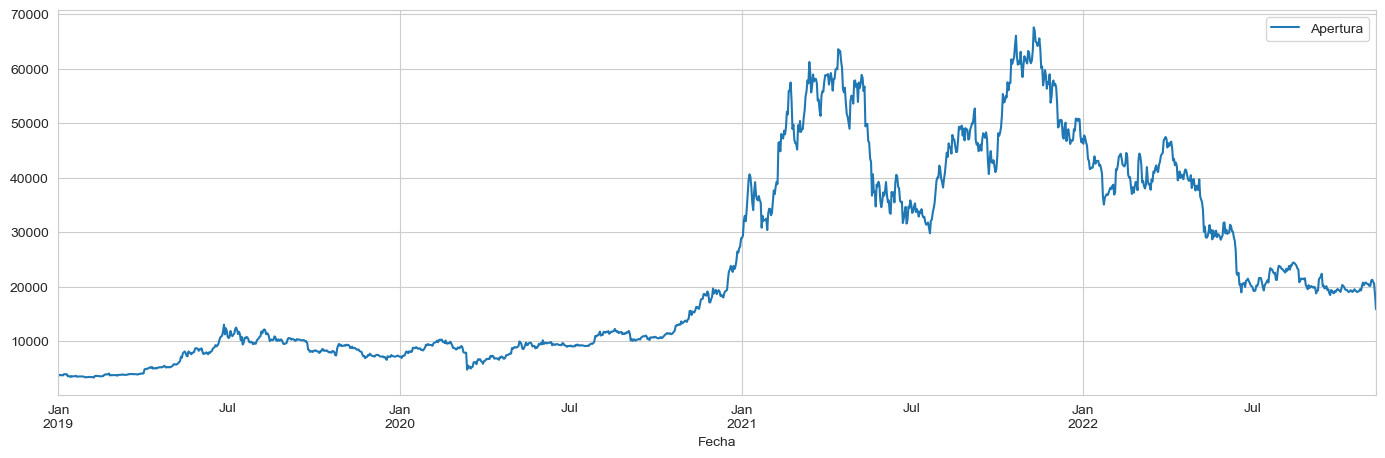

In [14]:
features.plot(subplots=True)

## Separacion(Entrenamiento-Validación-Prueba) y Normalización.

In [15]:
column_indices = {name: i for i, name in enumerate(features.columns)}

n = len(features)
train_df = features[0:int(n*0.7)]
val_df = features[int(n*0.7):int(n*0.9)]
test_df = features[int(n*0.9):]

num_features = features.shape[1]
train_mean = train_df.mean()

In [16]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [17]:
train_df

,Apertura
Fecha,
2022-11-10,-0.867991
2022-11-09,-0.712535
2022-11-08,-0.592358
2022-11-07,-0.573171
2022-11-06,-0.550755
...,...
2020-03-04,-1.285703
2020-03-03,-1.277214
2020-03-02,-1.298822


In [18]:
print("longitud dataframe entrenamiento:",train_df.shape)
print("longitud dataframe validación:",val_df.shape)
print("longitud dataframe prueba:",test_df.shape)

longitud dataframe entrenamiento: (986, 1)
longitud dataframe validación: (283, 1)
longitud dataframe prueba: (141, 1)


In [19]:
df_std = (features - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
df_std

,Column,Normalized
0,Apertura,-0.867991
1,Apertura,-0.712535
2,Apertura,-0.592358
3,Apertura,-0.573171
4,Apertura,-0.550755
...,...,...
1405,Apertura,-1.576372
1406,Apertura,-1.577679
1407,Apertura,-1.572192
1408,Apertura,-1.575967


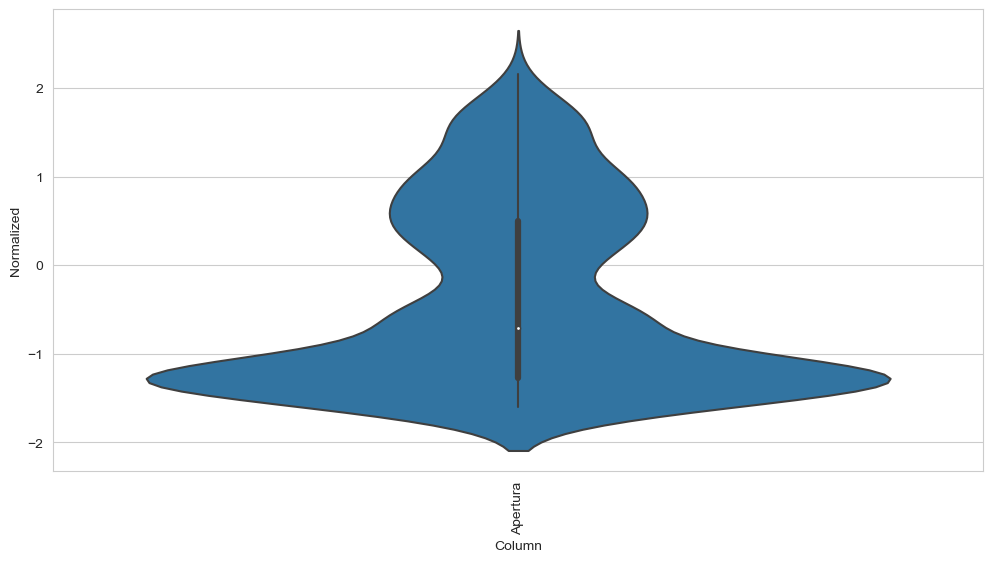

In [20]:
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(features.keys(), rotation=90)

## Clase WindowGenerator

In [21]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

## Split
Dada una lista de entradas consecutivas, el método split_window las convertirá en una ventana de entradas y una ventana de etiquetas.

In [22]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

## Transforma nuestros objetos a tipo tensorflow
Acá debe especificarse el tamaño del lote en batch_size=128 por defecto en la función make_dataset. Debe tener shuffle=False en el argumento de la función.

In [23]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=False,
      batch_size=128,)## cambiar 128

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [24]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [25]:
def plot(self, model=None, plot_col='Apertura', max_subplots=2):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

## Definir las gráficas para visulaizar lo que se desea predecir en términos de las entradas
Note que puede cambiar el nombre de la variable que va a visualiza usando el argumento plot_col

In [26]:
def plot(self, model=None, plot_col='Apertura', max_subplots=2):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

## Configuración para el ajuste de los modelos

In [27]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=0):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

# Modelamiento para la predicción de un solo paso

## RNN(LSTM)

In [125]:
single_step_window = WindowGenerator(# hacemo la configuracion para solucionar el problema que nos intereasa
    input_width=1, label_width=1, shift=1,
    label_columns=['Apertura'])
val_performance = {}
performance = {}
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['Apertura']

In [126]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(64, return_sequences=True,activation='tanh'),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])
# la red tiene una sola capa, de 64 unidades, que retorna secuencias, con su respectiva funcion de activacion, el reconoce de entrada
# una capa de salida, con numero de unidades uno porque la respuesta es univariada

In [127]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', lstm_model(single_step_window.example[0]).shape)

Input shape: (128, 1, 1)
Output shape: (128, 1, 1)


In [128]:
history = compile_and_fit(lstm_model, single_step_window)# modelo y la ventana configurada para solucionar nuestro problema

# guarda(?) los valores 
val_performance['LSTM'] = lstm_model.evaluate(single_step_window.val)
performance['LSTM'] = lstm_model.evaluate(single_step_window.test, verbose=0)

3/3 [==============================] - 0s 1ms/step - loss: 1.3946 - mean_absolute_error: 1.1786


In [129]:
lstm_model.evaluate(single_step_window.test,verbose=1)

2/2 [==============================] - 0s 2ms/step - loss: 2.0611 - mean_absolute_error: 1.4344


[2.0611467361450195, 1.4343585968017578]

<AxesSubplot:>

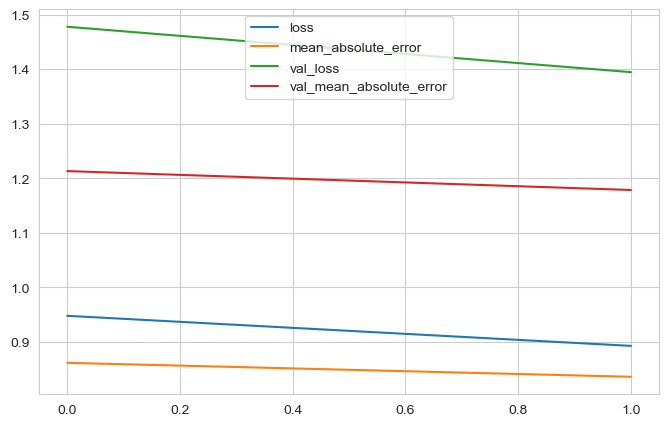

In [130]:
pd.DataFrame(history.history).plot(figsize=(8,5))

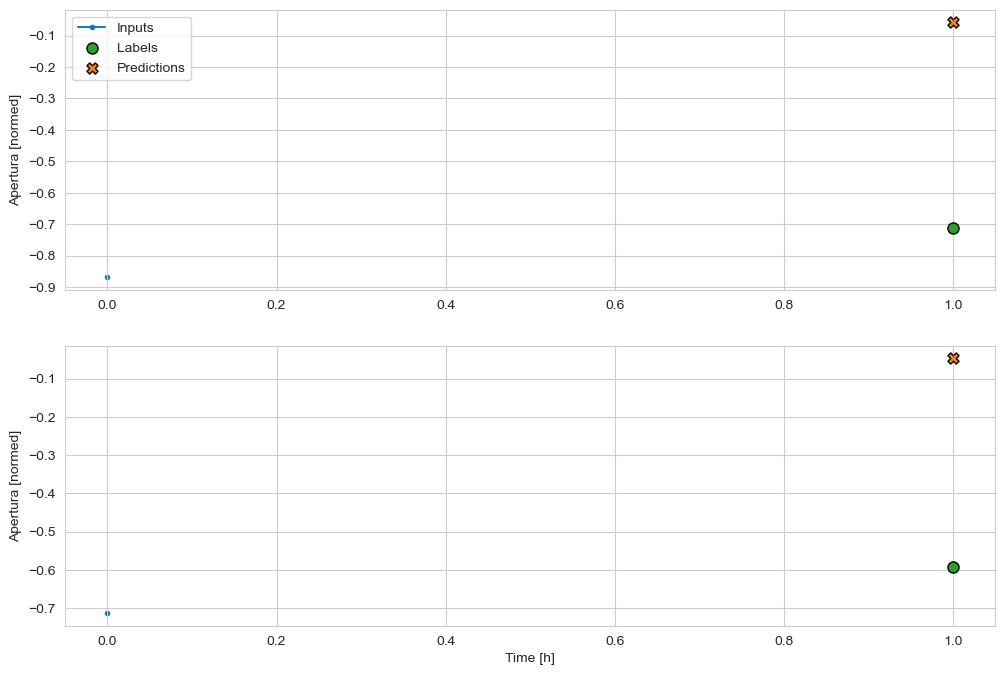

In [131]:
single_step_window.plot(lstm_model)

## Prediccion

In [132]:
test_df.shape

(141, 1)

In [133]:
input_predict=tf.constant(np.array(test_df.iloc[140]),dtype=tf.float32, shape=(1,1,1))
input_predict_mlp=input_predict
print(input_predict)
# valor a predecir(?)

tf.Tensor([[[-1.5818412]]], shape=(1, 1, 1), dtype=float32)


In [134]:
lstm_model.predict(input_predict_mlp)# prediccion?

1/1 [==============================] - 0s 201ms/step


array([[[-0.10661608]]], dtype=float32)

# Errores de Predicción del Modelo

## Sobre el conjunto de entrenamiento

In [135]:
labels_train = np.concatenate([y for x, y in single_step_window.train], axis=0)

In [136]:
labels_train

array([[[-0.7125355 ]],

       [[-0.59235775]],

       [[-0.57317126]],

       [[-0.55075485]],

       [[-0.55972373]],

       [[-0.6147859 ]],

       [[-0.61785764]],

       [[-0.5985774 ]],

       [[-0.5978036 ]],

       [[-0.5901888 ]],

       [[-0.5794378 ]],

       [[-0.59205294]],

       [[-0.6097094 ]],

       [[-0.58177674]],

       [[-0.6217969 ]],

       [[-0.6660553 ]],

       [[-0.6520216 ]],

       [[-0.6735001 ]],

       [[-0.6759739 ]],

       [[-0.6829908 ]],

       [[-0.6781722 ]],

       [[-0.6662664 ]],

       [[-0.65335816]],

       [[-0.6701353 ]],

       [[-0.6814725 ]],

       [[-0.6748543 ]],

       [[-0.66324157]],

       [[-0.67644286]],

       [[-0.6820763 ]],

       [[-0.67763287]],

       [[-0.65961295]],

       [[-0.66110194]],

       [[-0.654425  ]],

       [[-0.6290893 ]],

       [[-0.6176525 ]],

       [[-0.6069249 ]],

       [[-0.6485923 ]],

       [[-0.6821291 ]],

       [[-0.6672219 ]],

       [[-0.66071504]],



In [137]:
labels_train.shape

(985, 1, 1)

In [138]:
lista=list(single_step_window.train.unbatch().map(lambda x, y: (x, y)))

In [139]:
prediccion_intra_muestra=lstm_model.predict(single_step_window.train, verbose=1)

8/8 [==============================] - 0s 858us/step


In [140]:
prediccion_intra_muestra

array([[[-0.05835619]],

       [[-0.0476025 ]],

       [[-0.0392493 ]],

       [[-0.03791299]],

       [[-0.03635087]],

       [[-0.03697599]],

       [[-0.04081051]],

       [[-0.04102425]],

       [[-0.03968234]],

       [[-0.03962847]],

       [[-0.03909828]],

       [[-0.03834952]],

       [[-0.03922808]],

       [[-0.04045722]],

       [[-0.03851243]],

       [[-0.04129833]],

       [[-0.04437549]],

       [[-0.04340021]],

       [[-0.04489269]],

       [[-0.04506452]],

       [[-0.04555184]],

       [[-0.04521721]],

       [[-0.04439015]],

       [[-0.04349311]],

       [[-0.04465894]],

       [[-0.04544641]],

       [[-0.04498675]],

       [[-0.04417998]],

       [[-0.0450971 ]],

       [[-0.04548834]],

       [[-0.04517975]],

       [[-0.04392783]],

       [[-0.0440313 ]],

       [[-0.04356727]],

       [[-0.04180563]],

       [[-0.04100997]],

       [[-0.04026342]],

       [[-0.04316183]],

       [[-0.045492  ]],

       [[-0.04445654]],



In [141]:
prediccion_intra_muestra.shape

(985, 1, 1)

In [142]:
eror_prediction_train=labels_train-prediccion_intra_muestra

In [143]:
eror_prediction_train

array([[[-0.65417933]],

       [[-0.5447553 ]],

       [[-0.53392196]],

       [[-0.5128419 ]],

       [[-0.5233729 ]],

       [[-0.57780993]],

       [[-0.5770471 ]],

       [[-0.5575531 ]],

       [[-0.55812126]],

       [[-0.55056036]],

       [[-0.5403395 ]],

       [[-0.5537034 ]],

       [[-0.5704813 ]],

       [[-0.54131955]],

       [[-0.5832845 ]],

       [[-0.624757  ]],

       [[-0.6076461 ]],

       [[-0.6300999 ]],

       [[-0.6310812 ]],

       [[-0.6379263 ]],

       [[-0.63262033]],

       [[-0.62104917]],

       [[-0.608968  ]],

       [[-0.6266422 ]],

       [[-0.6368135 ]],

       [[-0.6294079 ]],

       [[-0.61825484]],

       [[-0.6322629 ]],

       [[-0.63697916]],

       [[-0.6321445 ]],

       [[-0.6144332 ]],

       [[-0.6171741 ]],

       [[-0.6103937 ]],

       [[-0.58552206]],

       [[-0.57584685]],

       [[-0.5659149 ]],

       [[-0.6083289 ]],

       [[-0.6389673 ]],

       [[-0.6217299 ]],

       [[-0.6162585 ]],



In [144]:
x_vals = train_df.index[1:]

In [145]:
print(eror_prediction_train.shape)
print(x_vals.shape)

(985, 1, 1)
(985,)


In [146]:
eror_prediction_train=eror_prediction_train.reshape(eror_prediction_train.shape[0])

In [147]:
eror_prediction_train

array([-0.65417933, -0.5447553 , -0.53392196, -0.5128419 , -0.5233729 ,
       -0.57780993, -0.5770471 , -0.5575531 , -0.55812126, -0.55056036,
       -0.5403395 , -0.5537034 , -0.5704813 , -0.54131955, -0.5832845 ,
       -0.624757  , -0.6076461 , -0.6300999 , -0.6310812 , -0.6379263 ,
       -0.63262033, -0.62104917, -0.608968  , -0.6266422 , -0.6368135 ,
       -0.6294079 , -0.61825484, -0.6322629 , -0.63697916, -0.6321445 ,
       -0.6144332 , -0.6171741 , -0.6103937 , -0.58552206, -0.57584685,
       -0.5659149 , -0.6083289 , -0.6389673 , -0.6217299 , -0.6162585 ,
       -0.60671586, -0.61756355, -0.63660127, -0.62670624, -0.652253  ,
       -0.6433685 , -0.62256813, -0.6172648 , -0.67143244, -0.6450182 ,
       -0.60768026, -0.6175056 , -0.57618153, -0.5972573 , -0.6019036 ,
       -0.5709863 , -0.5758517 , -0.4455351 , -0.48735642, -0.49598598,
       -0.5120253 , -0.6307326 , -0.6245755 , -0.65345246, -0.59239995,
       -0.58439636, -0.59506893, -0.58731556, -0.57732594, -0.58

In [148]:
eror_prediction_train.shape

(985,)

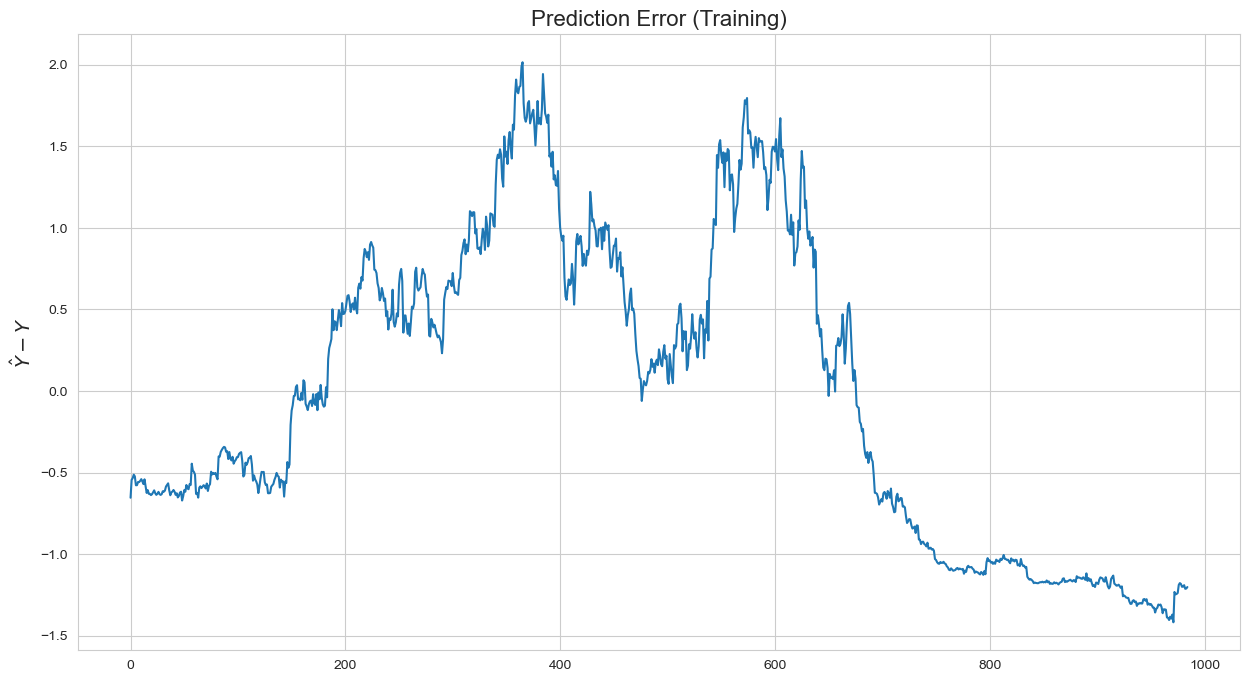

In [149]:
fig = plt.figure(figsize=(15,8))
plt.plot(eror_prediction_train)
plt.ylabel('$\hat{Y}-Y$', fontsize=14)# idealmente debe ser iid, o estacionario para poder estimar de manera correcta el riesgo, lo mas importatnte es que el modelo no tenga con tendencia
plt.title('Prediction Error (Training)', fontsize=16);# y se esta minimizando el riesgo de forma correcta

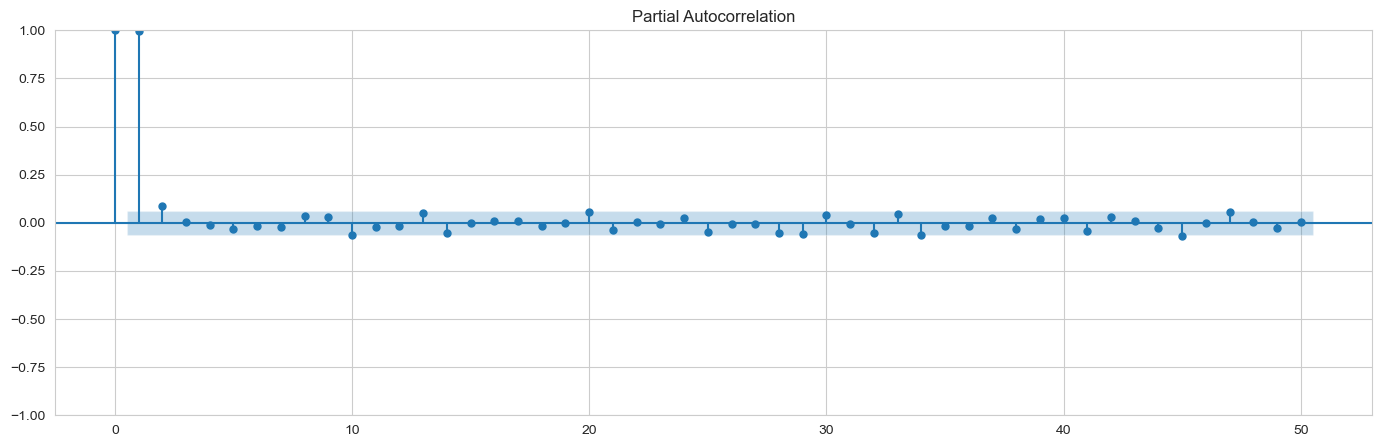

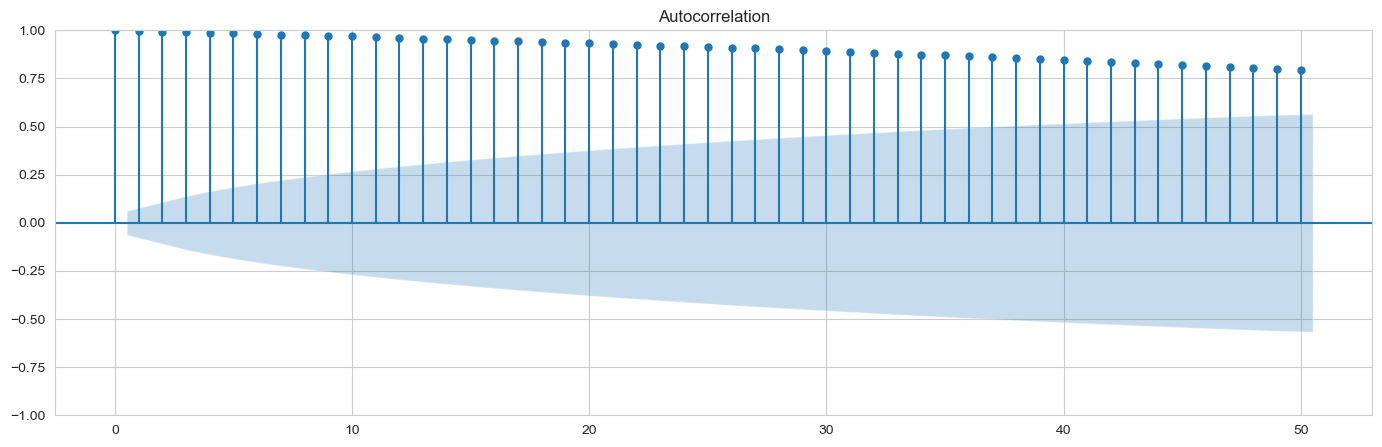

In [150]:
raficapacf=plot_pacf(eror_prediction_train,lags=50,method='ldbiased') ###Se puede usar también em method='ywmle'
graficaacf=plot_acf(eror_prediction_train,lags=50,adjusted='ldbiased')

## Sobre el conjunto de Prueba

In [151]:
labels_test = np.concatenate([y for x, y in single_step_window.test], axis=0)

In [152]:
prediccion_conjunto_test=lstm_model.predict(single_step_window.test, verbose=1)# abajo aparece 2 porque es el numero de lotes

2/2 [==============================] - 0s 1ms/step


In [153]:
eror_prediction_test=labels_test-prediccion_conjunto_test

In [154]:
eror_prediction_test.shape

(140, 1, 1)

In [155]:
eror_prediction_test=eror_prediction_test.reshape(eror_prediction_test.shape[0])

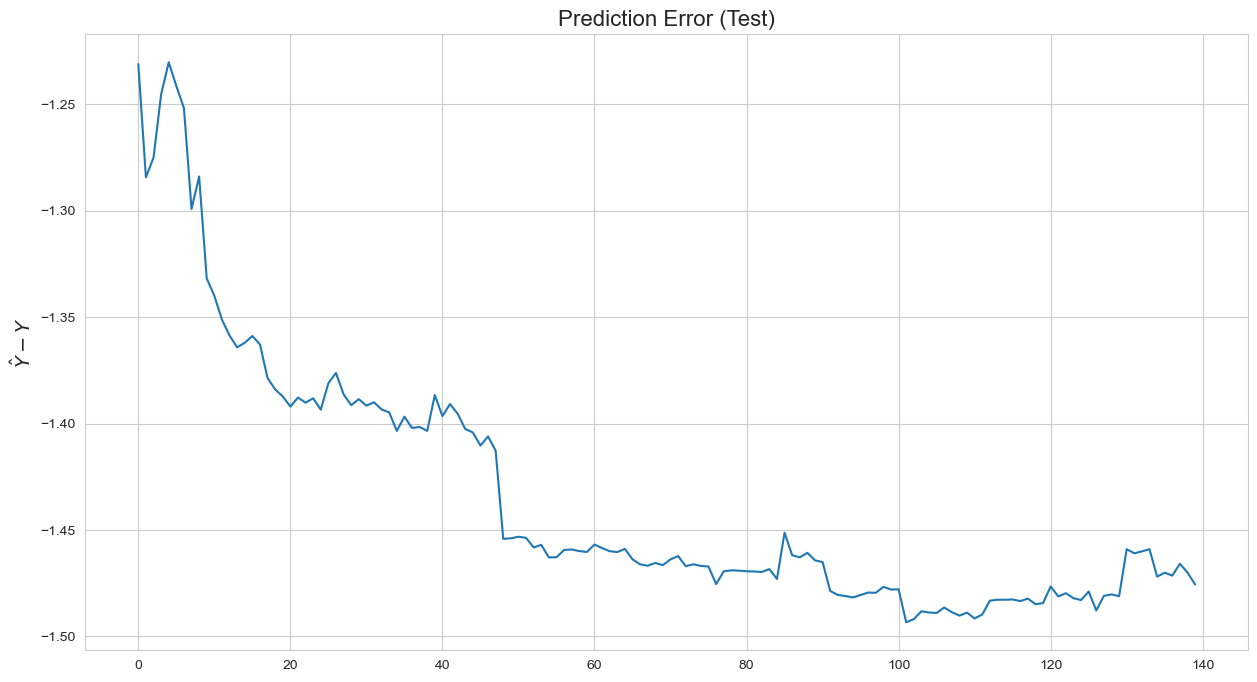

In [156]:
fig1 = plt.figure(figsize=(15,8))
plt.plot(eror_prediction_test)
plt.ylabel('$\hat{Y}-Y$', fontsize=14)
plt.title('Prediction Error (Test)', fontsize=16);

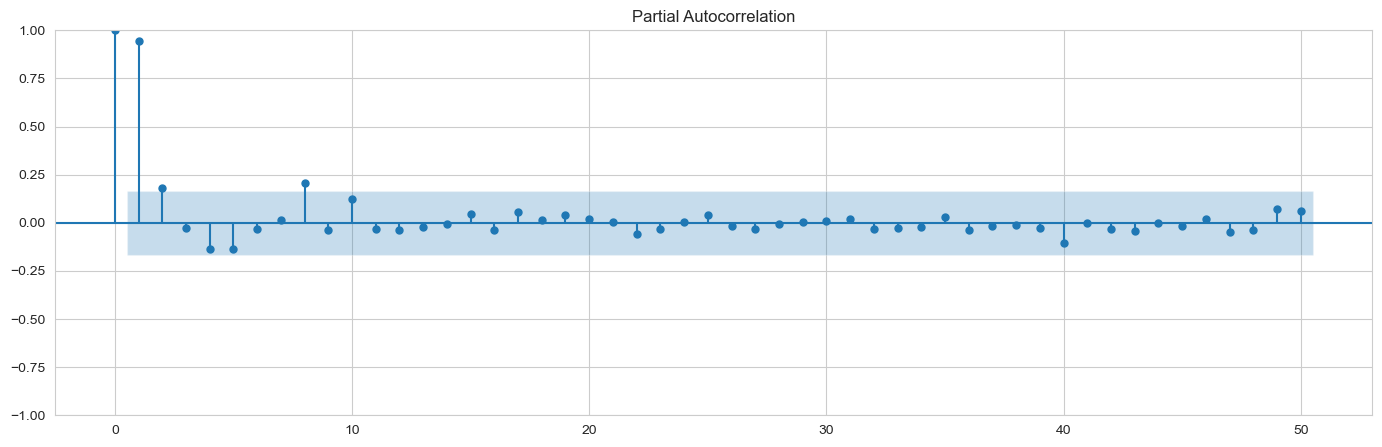

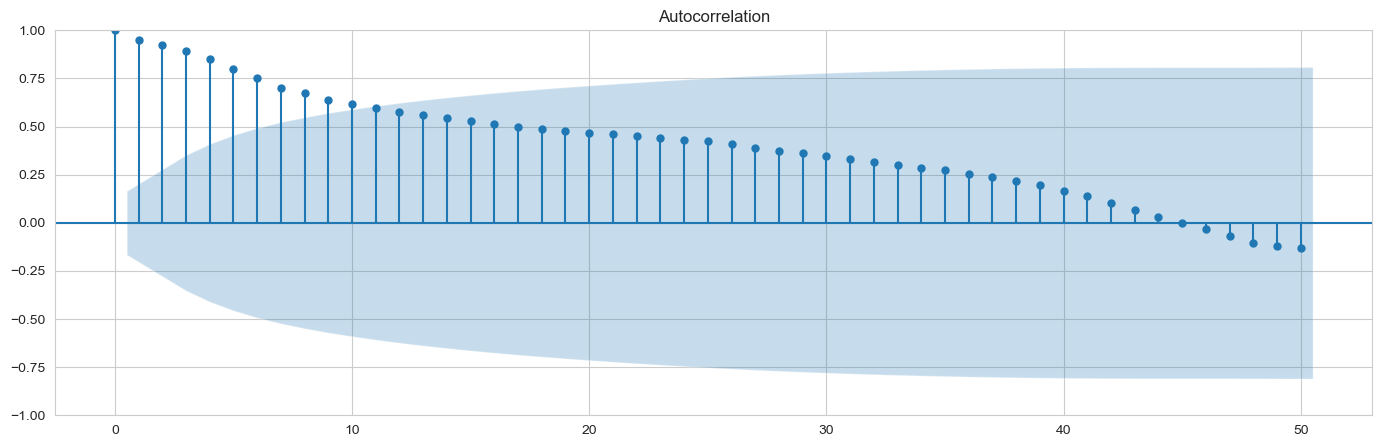

In [157]:
graficapacf=plot_pacf(eror_prediction_test,lags=50,method='ldbiased') ###Se puede usar también em method='ywmle'
graficaacf=plot_acf(eror_prediction_test,lags=50,adjusted='ldbiased')

## Gráfica en el conjunto de prueba.

In [158]:
test_index=test_df.index[:140]
prediction_test=(lstm_model.predict(single_step_window.test, verbose=1)*train_std['Apertura']+train_mean['Apertura'])
target_dataset_test = single_step_window.test.map(lambda x,y: y)

2/2 [==============================] - 0s 1ms/step


In [159]:
print(prediction_test.shape)
print(prediction_test)

(140, 1, 1)
[[[29158.623]]

 [[29171.49 ]]

 [[29111.44 ]]

 [[29118.008]]

 [[29152.367]]

 [[29172.055]]

 [[29160.625]]

 [[29147.967]]

 [[29092.873]]

 [[29106.621]]

 [[29052.89 ]]

 [[29040.057]]

 [[29026.469]]

 [[29017.066]]

 [[29010.148]]

 [[29012.12 ]]

 [[29015.828]]

 [[29011.645]]

 [[28993.385]]

 [[28986.139]]

 [[28981.918]]

 [[28976.225]]

 [[28980.676]]

 [[28978.236]]

 [[28980.396]]

 [[28974.484]]

 [[28988.2  ]]

 [[28994.557]]

 [[28983.605]]

 [[28977.074]]

 [[28979.865]]

 [[28976.596]]

 [[28978.178]]

 [[28974.424]]

 [[28972.684]]

 [[28962.68 ]]

 [[28969.562]]

 [[28964.047]]

 [[28964.193]]

 [[28962.102]]

 [[28981.027]]

 [[28971.11 ]]

 [[28976.861]]

 [[28972.113]]

 [[28963.654]]

 [[28961.26 ]]

 [[28954.127]]

 [[28958.52 ]]

 [[28951.262]]

 [[28903.98 ]]

 [[28901.15 ]]

 [[28901.78 ]]

 [[28901.244]]

 [[28896.09 ]]

 [[28897.148]]

 [[28890.615]]

 [[28890.24 ]]

 [[28894.049]]

 [[28894.564]]

 [[28893.76 ]]

 [[28893.217]]

 [[28897.115

In [160]:
i=1
for batch in target_dataset_test.take(2):
    if i==1:
        targets_test = batch.numpy()
    elif i>1:
        targets_test_aux = batch.numpy()
        targets_test=np.append(targets_test,targets_test_aux)
    i=i+1
print(targets_test.shape)
true_series=targets_test*train_std['Apertura']+train_mean['Apertura']
true_series=true_series.reshape((140,1,1))
print(true_series.shape)

(140,)
(140, 1, 1)


RECM: 289780.7347633724


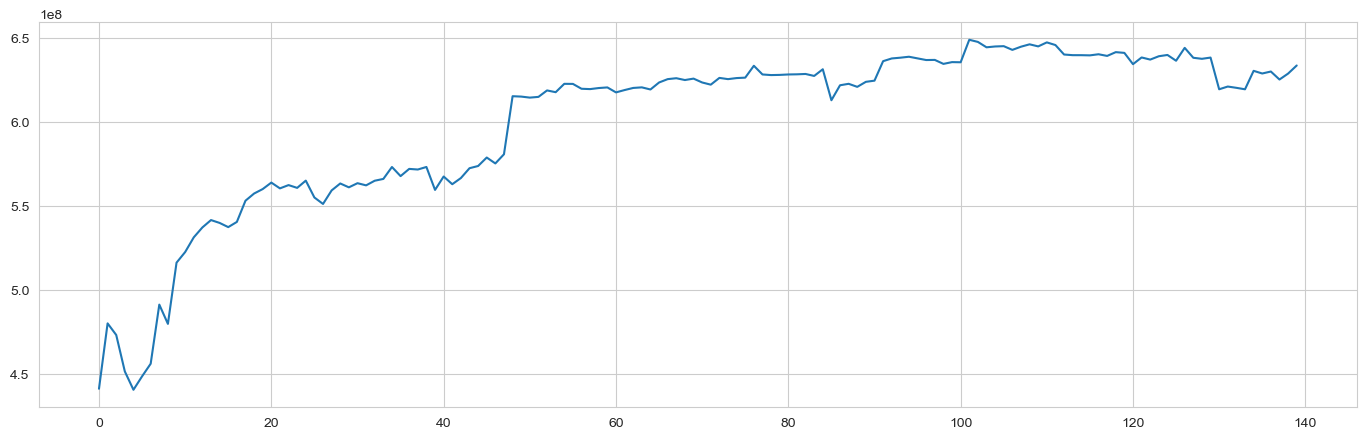

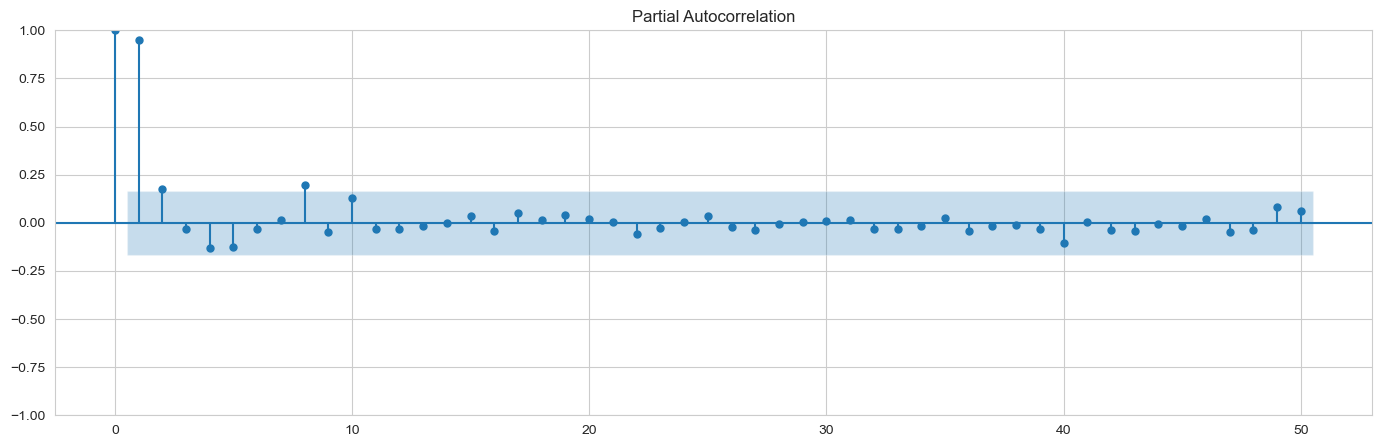

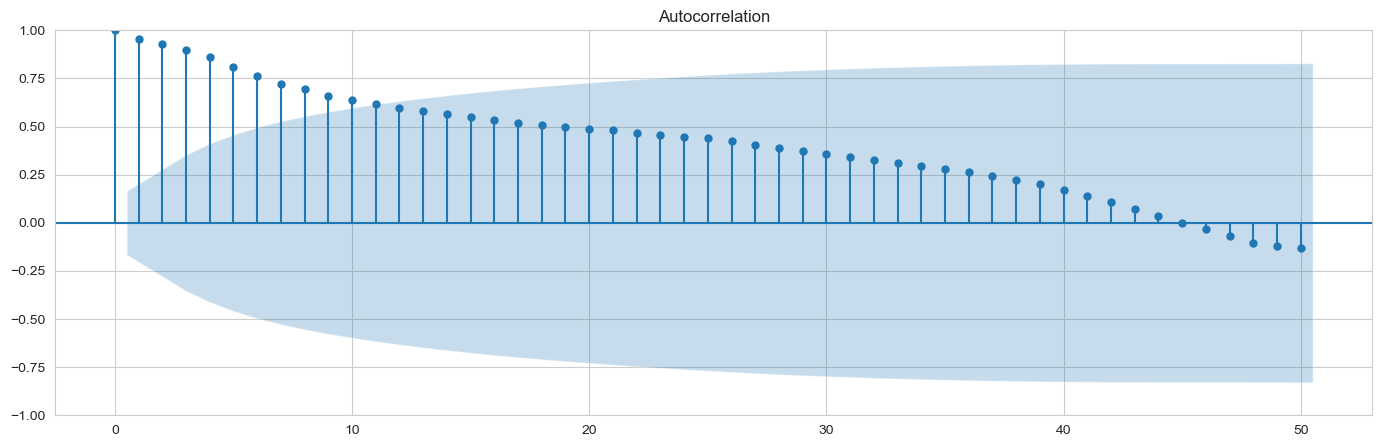

In [161]:
errors_squared=tf.keras.metrics.mean_squared_error(true_series, prediction_test).numpy()
print("RECM:",errors_squared.sum()**0.5)
plt.plot(errors_squared)
raficapacf=plot_pacf(errors_squared,lags=50,method='ldbiased') ###Se puede usar también em method='ywmle'
graficaacf=plot_acf(errors_squared,lags=50,adjusted='ldbiased')

In [162]:
true_series_final=true_series.reshape(140)
prediction_test_final=prediction_test.reshape(140)

Text(0, 0.5, 'Y y $\\hat{Y}$ en conjunto de prueba')

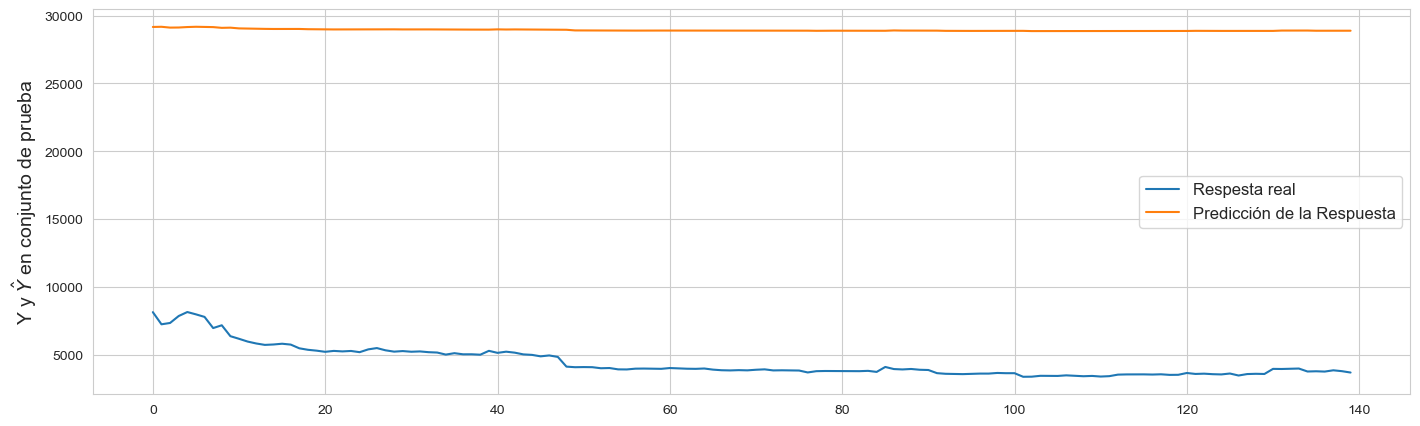

In [163]:
plt.plot(true_series_final)
plt.plot(prediction_test_final)
plt.legend(['Respesta real','Predicción de la Respuesta'],loc="best", fontsize=12)
plt.ylabel('Y y $\hat{Y}$ en conjunto de prueba', fontsize=14)

## Turner LSTM

In [164]:
from tensorflow import keras
import keras_tuner as kt
from tensorflow.keras import layers

In [165]:
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.LSTM(units=hp.Int('input_unit',min_value=32,max_value=512,step=32),activation=hp.Choice("activation", ["relu", "tanh"]),return_sequences=True))
    for i in range(hp.Int('n_layers', 1, 4)):
        model.add(layers.LSTM(hp.Int(f'lstm_{i}_units',min_value=32,max_value=512,step=32),activation=hp.Choice("activation", ["relu", "tanh"]),return_sequences=True))
    model.add(layers.LSTM(hp.Int('layer_2_neurons',min_value=32,max_value=512,step=32),activation=hp.Choice("activation", ["relu", "tanh"])))
    model.add(layers.Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(layers.Dense(1, activation="linear"))
    model.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mse'])
    return model

In [1]:
tuner_LSTM = kt.RandomSearch(
    hypermodel=build_model,
    objective="val_loss",
    max_trials=5,
    executions_per_trial=1,
    overwrite=True,
    directory="dirsalida",
    project_name="helloworld",
)

NameError: name 'kt' is not defined

In [167]:
stop_early=tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=0)

In [168]:
tuner_LSTM.search_space_summary()

Search space summary
Default search space size: 6
input_unit (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
n_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': None}
lstm_0_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
layer_2_neurons (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
Dropout_rate (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}


In [169]:
tuner_LSTM.search((single_step_window.train), epochs=5, validation_data=(single_step_window.val),callbacks=[stop_early])

Trial 3 Complete [00h 00m 05s]
val_loss: 1.0208595991134644

Best val_loss So Far: 1.0208595991134644
Total elapsed time: 00h 00m 16s
INFO:tensorflow:Oracle triggered exit


In [170]:
# Get the top 2 models.
models_LSTM = tuner_LSTM.get_best_models(num_models=2)
best_model_LSTM = models_LSTM[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model_LSTM.build(input_shape=(64, 1, 1))
best_model_LSTM.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (64, 1, 352)              498432    
                                                                 
 lstm_1 (LSTM)               (64, 1, 384)              1132032   
                                                                 
 lstm_2 (LSTM)               (64, 1, 352)              1037696   
                                                                 
 lstm_3 (LSTM)               (64, 96)                  172416    
                                                                 
 dropout (Dropout)           (64, 96)                  0         
                                                                 
 dense (Dense)               (64, 1)                   97        
                                                                 
Total params: 2,840,673
Trainable params: 2,840,673
Non-

In [171]:
tuner_LSTM.results_summary()

Results summary
Results in dirsalida\helloworld
Showing 10 best trials
Trial summary
Hyperparameters:
input_unit: 352
activation: tanh
n_layers: 2
lstm_0_units: 384
layer_2_neurons: 96
Dropout_rate: 0.30000000000000004
lstm_1_units: 352
lstm_2_units: 256
lstm_3_units: 480
Score: 1.0208595991134644
Trial summary
Hyperparameters:
input_unit: 288
activation: tanh
n_layers: 3
lstm_0_units: 384
layer_2_neurons: 32
Dropout_rate: 0.30000000000000004
lstm_1_units: 448
lstm_2_units: 448
lstm_3_units: 64
Score: 1.411597728729248
Trial summary
Hyperparameters:
input_unit: 224
activation: relu
n_layers: 4
lstm_0_units: 96
layer_2_neurons: 320
Dropout_rate: 0.5
lstm_1_units: 32
lstm_2_units: 32
lstm_3_units: 32
Score: 1.6088309288024902


In [203]:
# Get the top 2 hyperparameters.
best_hps_LSTM = tuner_LSTM.get_best_hyperparameters(5)
# Build the model with the best hp.
callback=tf.keras.callbacks.EarlyStopping(monitor="loss",patience=0)
model_LSTM = build_model(best_hps_LSTM[0])
# Fit with the entire dataset.
IPython.display.clear_output()
val_performance['LSTMA'] = model_LSTM.evaluate(single_step_window.val)
performance['LSTMA'] = model_LSTM.evaluate(single_step_window.test, verbose=0)

3/3 [==============================] - 2s 6ms/step - loss: 1.6039 - mse: 1.6039


In [204]:
model_LSTM.evaluate(single_step_window.test,verbose=1)

2/2 [==============================] - 0s 3ms/step - loss: 2.3696 - mse: 2.3696


[2.3695828914642334, 2.3695828914642334]

<AxesSubplot:>

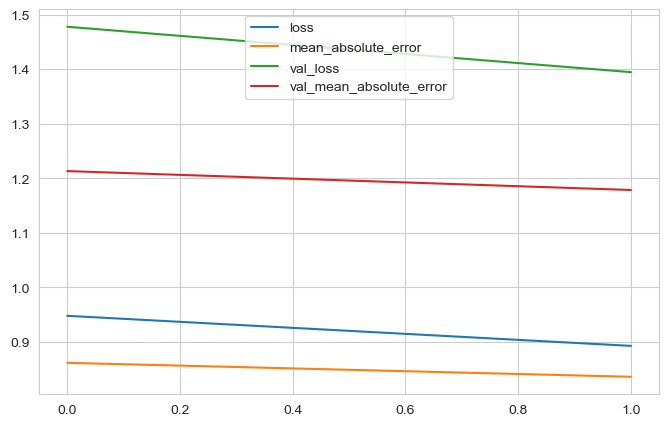

In [205]:
pd.DataFrame(history.history).plot(figsize=(8,5))

# Errores de Predicción del Modelo

## Sobre el conjunto de entrenamiento

In [206]:
labels_train = np.concatenate([y for x, y in single_step_window.train], axis=0)
labels_train.shape
labels_train=labels_train.reshape(labels_train.shape[0])
labels_train
labels_train.shape

(985,)

In [207]:
lista=list(single_step_window.train.unbatch().map(lambda x, y: (x, y)))
prediccion_intra_muestra=model_LSTM.predict(single_step_window.train, verbose=1)
prediccion_intra_muestra=prediccion_intra_muestra.reshape(prediccion_intra_muestra.shape[0])
prediccion_intra_muestra

8/8 [==============================] - 1s 5ms/step


array([-6.05483365e-06, -5.43548231e-06, -4.81591997e-06, -4.70573286e-06,
       -4.57300484e-06, -4.62658500e-06, -4.94081178e-06, -4.95760469e-06,
       -4.85095370e-06, -4.84664633e-06, -4.80358722e-06, -4.74204717e-06,
       -4.81415191e-06, -4.91293031e-06, -4.75553679e-06, -4.97899600e-06,
       -5.21038601e-06, -5.13881241e-06, -5.24766074e-06, -5.25994983e-06,
       -5.29449608e-06, -5.27076190e-06, -5.21143374e-06, -5.14567364e-06,
       -5.23088238e-06, -5.28703822e-06, -5.25438372e-06, -5.19612513e-06,
       -5.26225631e-06, -5.29007229e-06, -5.26814256e-06, -5.17766603e-06,
       -5.18529123e-06, -5.15120337e-06, -5.01824979e-06, -4.95648419e-06,
       -4.89746890e-06, -5.12105908e-06, -5.29027602e-06, -5.21623588e-06,
       -5.18338493e-06, -5.13206760e-06, -5.18411252e-06, -5.28293458e-06,
       -5.24066854e-06, -5.36256994e-06, -5.32818376e-06, -5.22316259e-06,
       -5.18893648e-06, -5.44933573e-06, -5.34230639e-06, -5.14851854e-06,
       -5.18493471e-06, -

In [208]:
prediccion_intra_muestra.shape


(985,)

In [209]:
eror_prediction_train=labels_train-prediccion_intra_muestra
eror_prediction_train
eror_prediction_train.shape

(985,)

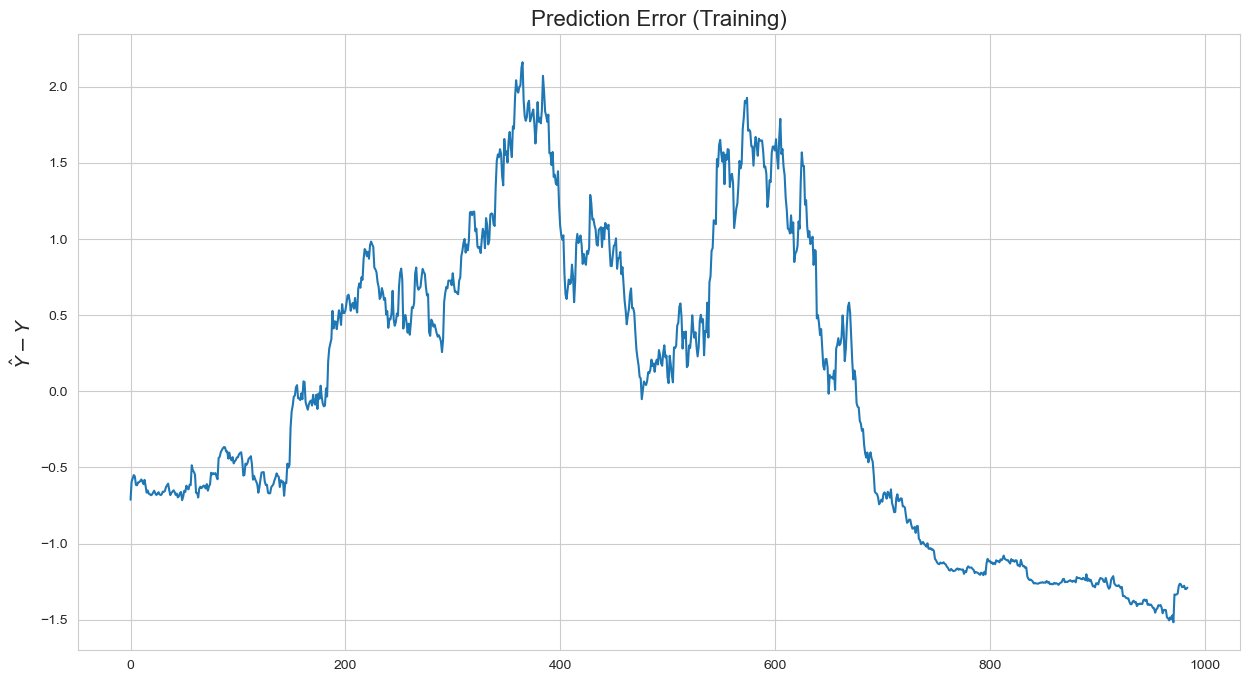

In [210]:
fig = plt.figure(figsize=(15,8))
plt.plot(eror_prediction_train)
plt.ylabel('$\hat{Y}-Y$', fontsize=14)# idealmente debe ser iid, o estacionario para poder estimar de manera correcta el riesgo, lo mas importatnte es que el modelo no tenga con tendencia
plt.title('Prediction Error (Training)', fontsize=16);# y se esta minimizando el riesgo de forma correcta

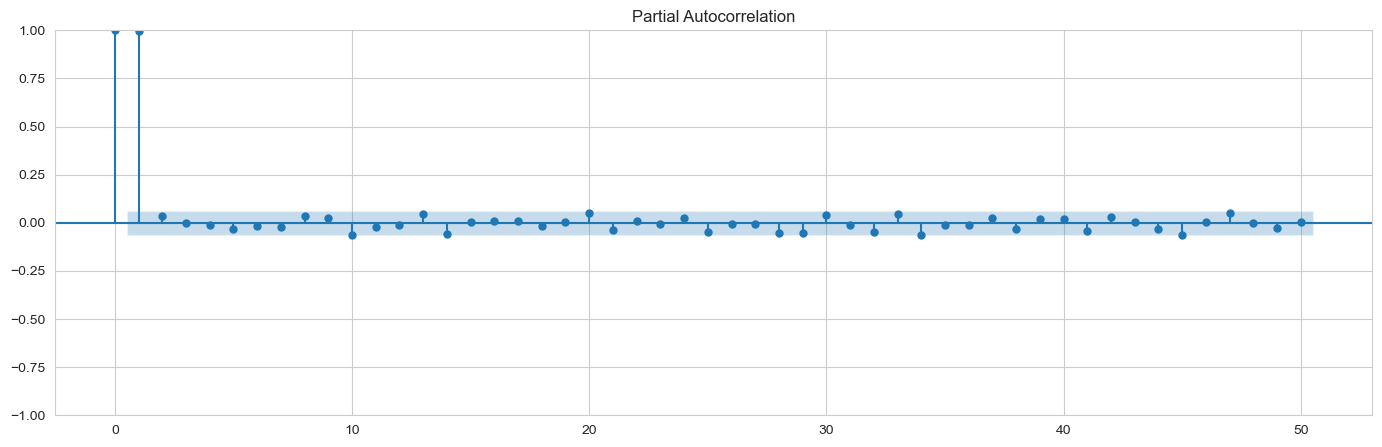

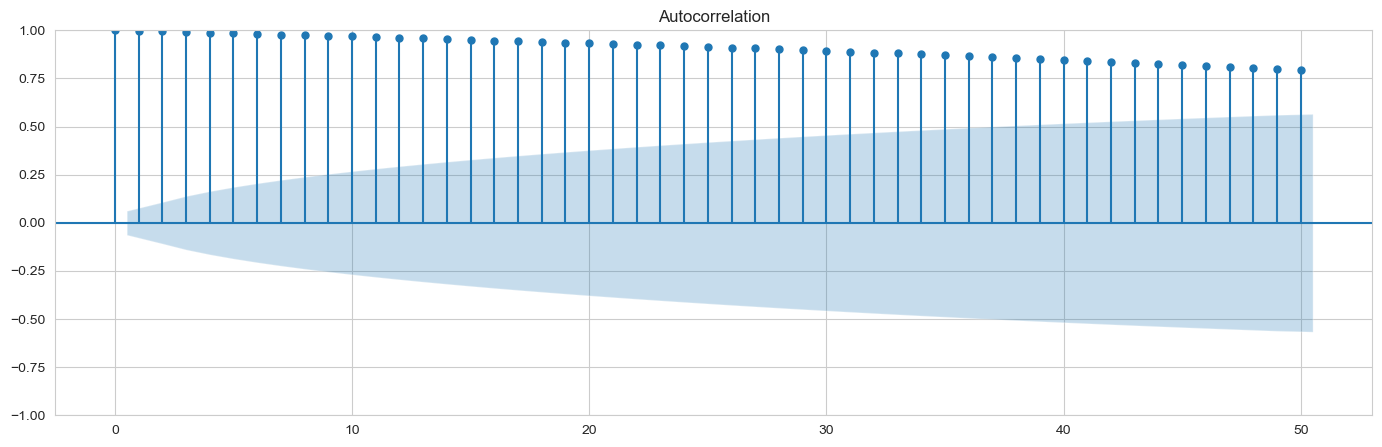

In [211]:
graficapacf=plot_pacf(eror_prediction_train,lags=50,method='ldbiased') ###Se puede usar también em method='ywmle'
graficaacf=plot_acf(eror_prediction_train,lags=50,adjusted='ldbiased')


## Sobre el conjunto de Prueba

In [212]:
train_plus_val=single_step_window.train.concatenate(single_step_window.val)###verificar que en efecto

In [213]:

model_LSTM.fit(train_plus_val, epochs=5,callbacks=[callback])

Epoch 1/5
11/11 [==============================] - 4s 17ms/step - loss: 1.1084 - mse: 1.1084
Epoch 2/5
11/11 [==============================] - 0s 17ms/step - loss: 0.5264 - mse: 0.5264


In [214]:
model_LSTM.predict(single_step_window.test, verbose=0)

array([[-1.4254649],
       [-1.4157289],
       [-1.4609797],
       [-1.4560534],
       [-1.4301902],
       [-1.415301 ],
       [-1.423951 ],
       [-1.4335105],
       [-1.4748722],
       [-1.4645892],
       [-1.5046333],
       [-1.5141394],
       [-1.5241802],
       [-1.5311116],
       [-1.5362047],
       [-1.5347548],
       [-1.5320243],
       [-1.5351027],
       [-1.5485154],
       [-1.5538255],
       [-1.5569146],
       [-1.561078 ],
       [-1.5578237],
       [-1.5596067],
       [-1.5580276],
       [-1.5623496],
       [-1.5523165],
       [-1.547657 ],
       [-1.5556794],
       [-1.5604566],
       [-1.5584165],
       [-1.5608062],
       [-1.5596505],
       [-1.5623932],
       [-1.5636642],
       [-1.5709635],
       [-1.5659426],
       [-1.5699667],
       [-1.5698603],
       [-1.5713842],
       [-1.557566 ],
       [-1.5648133],
       [-1.560612 ],
       [-1.5640813],
       [-1.5702523],
       [-1.5719982],
       [-1.5771912],
       [-1.57

In [215]:
labels_test = np.concatenate([y for x, y in single_step_window.test], axis=0)

In [216]:
model_LSTM.evaluate(single_step_window.test, verbose=0)

[0.003602157346904278, 0.003602157346904278]

In [217]:
prediccion_conjunto_test=model_LSTM.predict(single_step_window.test, verbose=1)# abajo aparece 2 porque es el numero de lotes
prediccion_conjunto_test=prediccion_conjunto_test.reshape(prediccion_conjunto_test.shape[0])
labels_test=labels_test.reshape(labels_test.shape[0])

2/2 [==============================] - 0s 4ms/step


In [218]:
eror_prediction_test=labels_test-prediccion_conjunto_test
eror_prediction_test.shape

(140,)

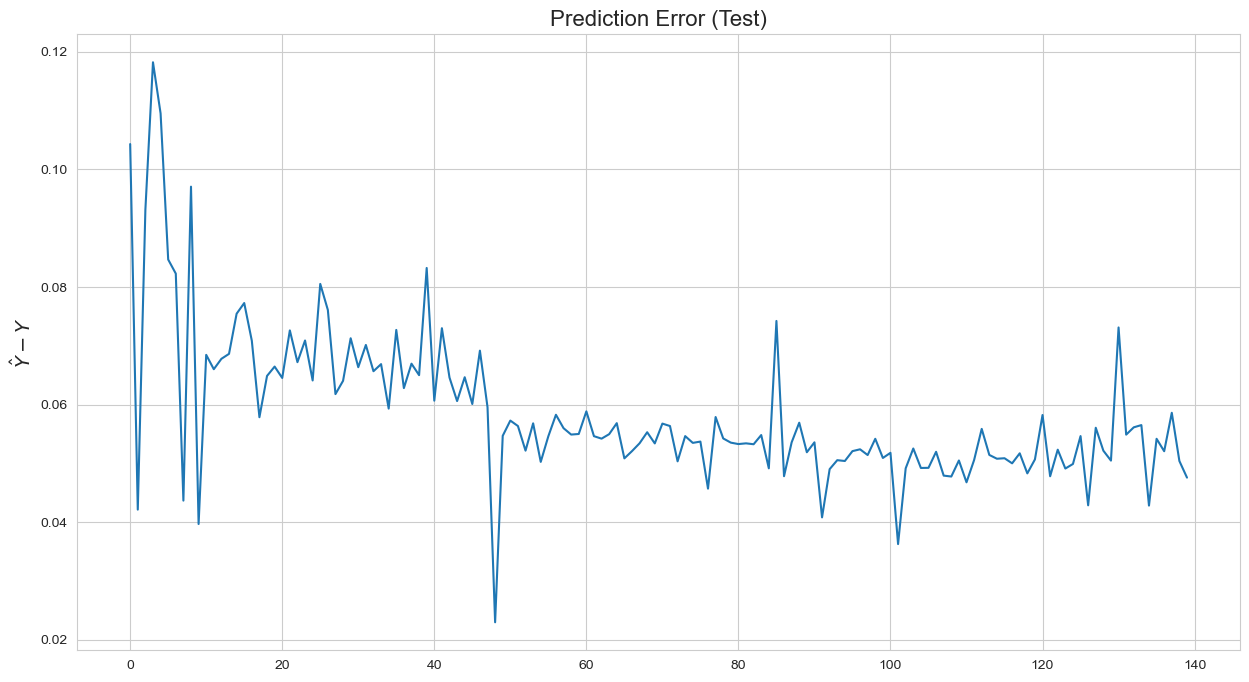

In [219]:
fig1 = plt.figure(figsize=(15,8))
plt.plot(eror_prediction_test)
plt.ylabel('$\hat{Y}-Y$', fontsize=14)
plt.title('Prediction Error (Test)', fontsize=16);

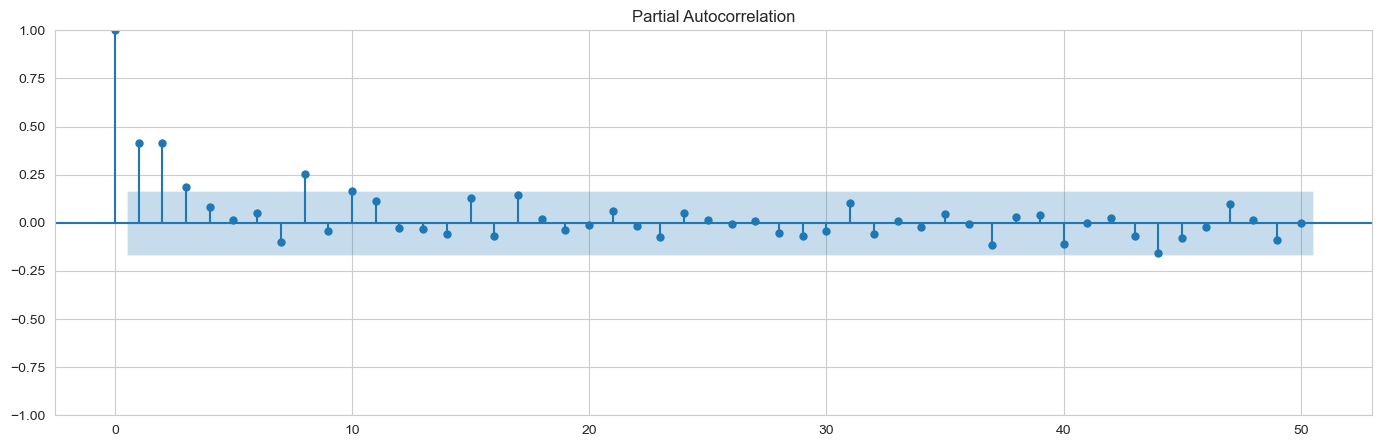

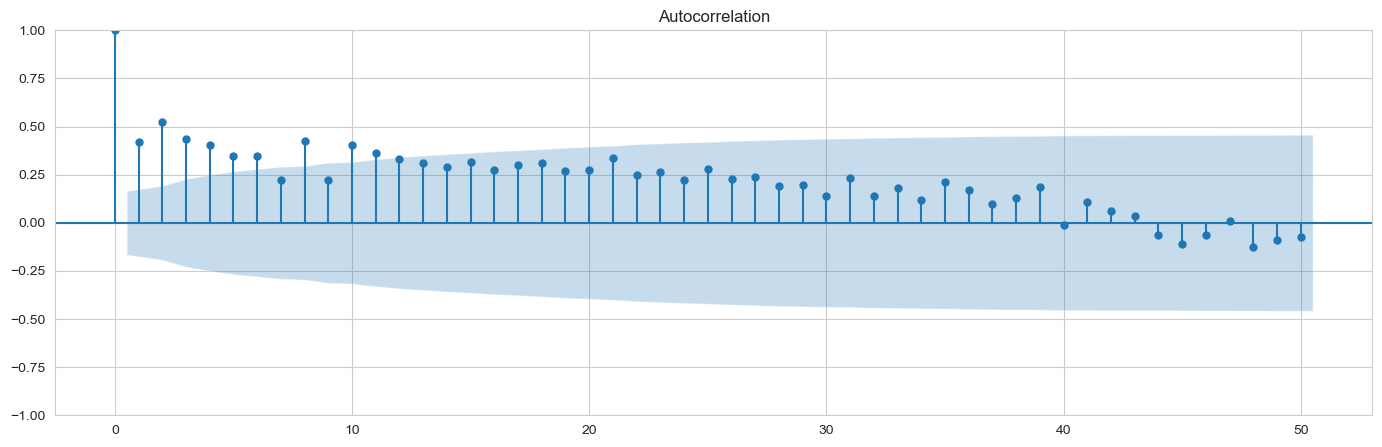

In [220]:
graficapacf=plot_pacf(eror_prediction_test,lags=50,method='ldbiased') ###Se puede usar también em method='ywmle'
graficaacf=plot_acf(eror_prediction_test,lags=50,adjusted='ldbiased')

In [221]:
prediccion_conjunto_test=prediccion_conjunto_test.reshape(prediccion_conjunto_test.shape[0])
prediccion_conjunto_test

array([-1.4254649, -1.4157289, -1.4609797, -1.4560534, -1.4301902,
       -1.415301 , -1.423951 , -1.4335105, -1.4748722, -1.4645892,
       -1.5046333, -1.5141394, -1.5241802, -1.5311116, -1.5362047,
       -1.5347548, -1.5320243, -1.5351027, -1.5485154, -1.5538255,
       -1.5569146, -1.561078 , -1.5578237, -1.5596067, -1.5580276,
       -1.5623496, -1.5523165, -1.547657 , -1.5556794, -1.5604566,
       -1.5584165, -1.5608062, -1.5596505, -1.5623932, -1.5636642,
       -1.5709635, -1.5659426, -1.5699667, -1.5698603, -1.5713842,
       -1.557566 , -1.5648133, -1.560612 , -1.5640813, -1.5702523,
       -1.5719982, -1.5771912, -1.5739945, -1.5792753, -1.613496 ,
       -1.6155325, -1.6150805, -1.6154659, -1.6191735, -1.6184136,
       -1.6231085, -1.6233789, -1.6206409, -1.6202706, -1.62085  ,
       -1.6212391, -1.6184373, -1.6195868, -1.6208595, -1.6212722,
       -1.6200901, -1.623981 , -1.6261327, -1.626791 , -1.6258056,
       -1.6265446, -1.6244171, -1.6230326, -1.6267673, -1.6263

In [222]:
eror_prediction_test.shape

(140,)

In [223]:
IPython.display.clear_output()
val_performance['LSTMA'] = model_LSTM.evaluate(single_step_window.val)
performance['LSTMA'] = model_LSTM.evaluate(single_step_window.test, verbose=0)

3/3 [==============================] - 0s 34ms/step - loss: 0.0107 - mse: 0.0107


## Gráfica en el conjunto de prueba

In [224]:
prediction_test=(model_LSTM.predict(single_step_window.test, verbose=1)*train_std['Apertura']+train_mean['Apertura'])

2/2 [==============================] - 0s 3ms/step


In [225]:
print(prediction_test.shape)
print(prediction_test)

(140, 1)
[[6377.1094]
 [6543.1934]
 [5771.2656]
 [5855.3027]
 [6296.5   ]
 [6550.494 ]
 [6402.9336]
 [6239.8594]
 [5534.2734]
 [5709.6914]
 [5026.582 ]
 [4864.42  ]
 [4693.135 ]
 [4574.8926]
 [4488.01  ]
 [4512.744 ]
 [4559.324 ]
 [4506.8086]
 [4278.002 ]
 [4187.418 ]
 [4134.7227]
 [4063.6992]
 [4119.215 ]
 [4088.7969]
 [4115.7344]
 [4042.0078]
 [4213.16  ]
 [4292.6465]
 [4155.793 ]
 [4074.2988]
 [4109.1016]
 [4068.336 ]
 [4088.0488]
 [4041.2637]
 [4019.58  ]
 [3895.0625]
 [3980.713 ]
 [3912.0684]
 [3913.8809]
 [3887.8867]
 [4123.6094]
 [3999.9785]
 [4071.6484]
 [4012.4648]
 [3907.1953]
 [3877.412 ]
 [3788.8242]
 [3843.3574]
 [3753.2734]
 [3169.5059]
 [3134.7637]
 [3142.4766]
 [3135.9004]
 [3072.6523]
 [3085.6172]
 [3005.5254]
 [3000.914 ]
 [3047.621 ]
 [3053.9375]
 [3044.0547]
 [3037.416 ]
 [3085.213 ]
 [3065.6016]
 [3043.8926]
 [3036.8516]
 [3057.0156]
 [2990.6426]
 [2953.9355]
 [2942.707 ]
 [2959.5156]
 [2946.9102]
 [2983.2031]
 [3006.8223]
 [2943.1113]
 [2950.787 ]
 [2941.0898]
 [2

In [226]:
i=1
for batch in target_dataset_test.take(329):
    if i==1:
        targets_test = batch.numpy()
    elif i>1:
        targets_test_aux = batch.numpy()
        targets_test=np.append(targets_test,targets_test_aux)
    i=i+1

In [227]:
print(targets_test.shape)
true_series=targets_test*train_std['Apertura']+train_mean['Apertura']
true_series=true_series.reshape((140,1,1))
print(true_series.shape)

(140,)
(140, 1, 1)


In [228]:
errors_squared=tf.keras.metrics.mean_squared_error(true_series, prediction_test).numpy()
print("RECM:",errors_squared.sum()**0.5)

RECM: 249785.7524199489


## Gráfica en el conjunto de prueba.

In [229]:
test_index=test_df.index[:140]
test_index.values

array(['2019-05-21T00:00:00.000000000', '2019-05-20T00:00:00.000000000',
       '2019-05-19T00:00:00.000000000', '2019-05-18T00:00:00.000000000',
       '2019-05-17T00:00:00.000000000', '2019-05-16T00:00:00.000000000',
       '2019-05-15T00:00:00.000000000', '2019-05-14T00:00:00.000000000',
       '2019-05-13T00:00:00.000000000', '2019-05-12T00:00:00.000000000',
       '2019-05-11T00:00:00.000000000', '2019-05-10T00:00:00.000000000',
       '2019-05-09T00:00:00.000000000', '2019-05-08T00:00:00.000000000',
       '2019-05-07T00:00:00.000000000', '2019-05-06T00:00:00.000000000',
       '2019-05-05T00:00:00.000000000', '2019-05-04T00:00:00.000000000',
       '2019-05-03T00:00:00.000000000', '2019-05-02T00:00:00.000000000',
       '2019-05-01T00:00:00.000000000', '2019-04-30T00:00:00.000000000',
       '2019-04-29T00:00:00.000000000', '2019-04-28T00:00:00.000000000',
       '2019-04-27T00:00:00.000000000', '2019-04-26T00:00:00.000000000',
       '2019-04-25T00:00:00.000000000', '2019-04-24

In [230]:
true_series_final=true_series.reshape(140)
prediction_test_final=prediction_test.reshape(140)

In [231]:
true_series_final

array([8156.4023, 7261.9023, 7359.9023, 7871.9023, 8164.801 , 7994.801 ,
       7806.4004, 6984.703 , 7190.002 , 6386.6016, 6194.301 , 5990.502 ,
       5849.4023, 5745.502 , 5775.1016, 5830.801 , 5768.002 , 5493.5996,
       5384.6016, 5321.1016, 5235.4004, 5302.4023, 5265.701 , 5298.201 ,
       5209.201 , 5415.5996, 5511.201 , 5346.502 , 5248.201 , 5290.201 ,
       5241.002 , 5264.801 , 5208.301 , 5182.1016, 5031.4004, 5135.1016,
       5052.    , 5054.201 , 5022.701 , 5307.701 , 5158.4023, 5245.002 ,
       5173.5   , 5046.1016, 5010.002 , 4902.502 , 4968.701 , 4859.301 ,
       4145.1016, 4102.301 , 4111.801 , 4103.701 , 4025.7012, 4041.7012,
       3942.8008, 3937.1016, 3994.8008, 4002.5996, 3990.4004, 3982.2012,
       4041.2012, 4017.002 , 3990.2012, 3981.502 , 4006.4004, 3924.4004,
       3879.002 , 3865.1016, 3885.9023, 3870.3027, 3915.2012, 3944.4023,
       3865.6016, 3875.1016, 3863.1016, 3857.2012, 3715.9023, 3809.7012,
       3823.2031, 3821.9004, 3816.7012, 3814.6016, 

Text(0, 0.5, 'Y y $\\hat{Y}$ en conjunto de prueba')

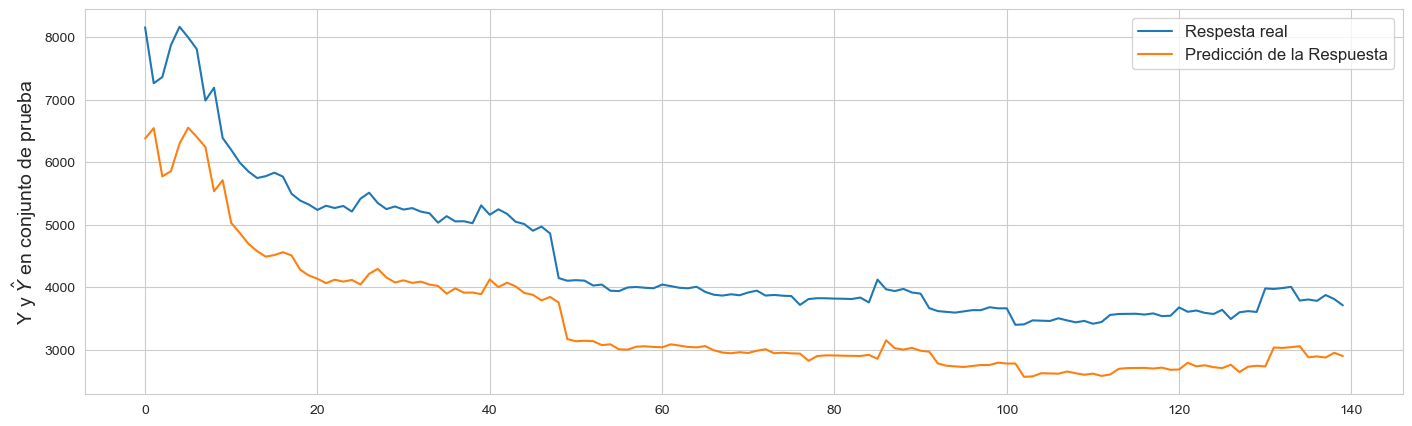

In [232]:
plt.plot(true_series_final)
plt.plot(prediction_test_final)
plt.legend(['Respesta real','Predicción de la Respuesta'],loc="best", fontsize=12)
plt.ylabel('Y y $\hat{Y}$ en conjunto de prueba', fontsize=14)

## Rendimiento

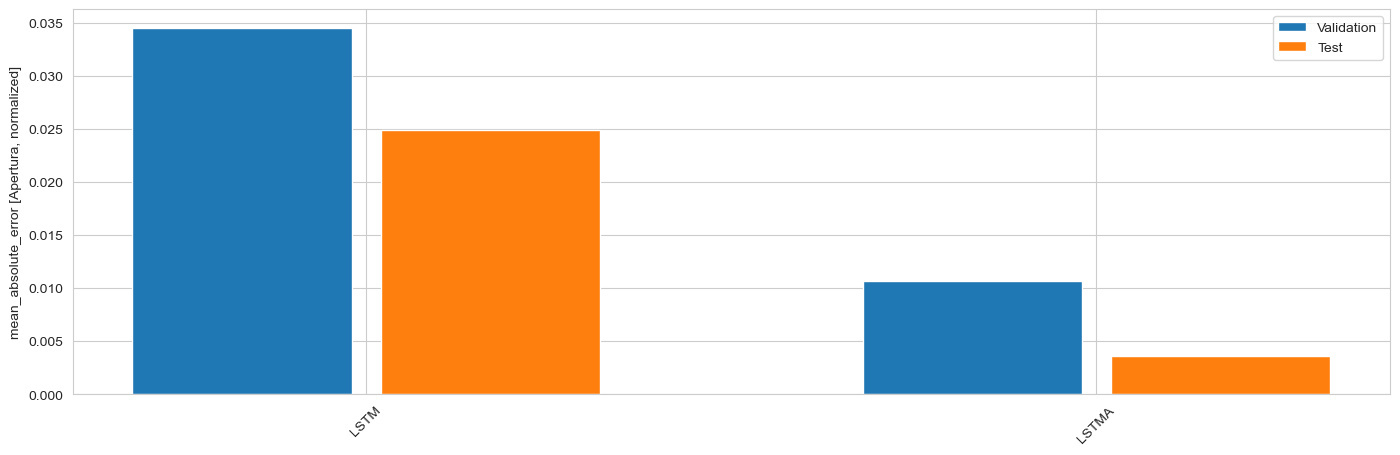

In [233]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [Apertura, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()